# Setup

In [23]:
# for data preprocessing
import os
import json
import sqlite3

import pandas as pd
import numpy as np
from collections import defaultdict

import datetime
import time
from datetime import date, timedelta

# for LSTM/RNN
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

# others
import warnings
warnings.filterwarnings("ignore")

## DataFrame from User 1

In [2]:
filepath = '../data/raw/user1/'

In [3]:
data = []
time_df = []

for filename in os.listdir(filepath):
    if 'temp' in filename:
        continue
    if filename == '.ipynb_checkpoints':
        continue
    cnx = sqlite3.connect(filepath + filename)
    cnx.text_factory = lambda b: b.decode(errors = 'ignore') #https://stackoverflow.com/questions/22751363/sqlite3-operationalerror-could-not-decode-to-utf-8-column
    df_string = pd.read_sql_query("SELECT * FROM COUNTERS_STRING_TIME_DATA", cnx)
    df_ull = pd.read_sql_query("SELECT * FROM COUNTERS_ULL_TIME_DATA", cnx)
    df_data = pd.concat([df_string, df_ull], ignore_index = True)
    start_val = pd.DataFrame({'MEASUREMENT_TIME': df_data.loc[0][0], 'ID_INPUT': 4, 'VALUE': 's0', 'PRIVATE_DATA': 0}, index =[0])
    df_data = pd.concat([start_val, df_data])
    data.append(pd.DataFrame(df_data))
    schema = pd.DataFrame(pd.read_sql_query("SELECT * FROM INPUTS", cnx))
    
    # get actual start time
    time_diff = pd.read_sql_query("SELECT * FROM DB_META_DATA", cnx)
    utc_open = pd.to_datetime(time_diff[time_diff['KEY'] == 'OPEN_TIME_UTC']['VALUE'].iloc[0])
    local_open = pd.to_datetime(time_diff[time_diff['KEY'] == 'OPEN_TIME_LOCAL']['VALUE'].iloc[0])
    time_difference = utc_open - local_open
    
    time_sub = df_data[df_data['ID_INPUT'] == 4].copy()
    time_sub['MEASUREMENT_TIME'] = pd.to_datetime(time_sub['MEASUREMENT_TIME'])
    time_sub['MEASUREMENT_TIME'] = time_sub['MEASUREMENT_TIME'] - time_difference
    time_sub['Time_Used'] = time_sub['MEASUREMENT_TIME'].diff().dt.total_seconds()
    time_sub['Time_Used'] = time_sub['Time_Used'].shift(periods = -1)
    time_sub = time_sub.drop(columns = ['PRIVATE_DATA', 'ID_INPUT'])
    time_df.append(time_sub)

In [4]:
df = pd.concat(data, ignore_index = True)

df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
df['PRIVATE_DATA'] = df['PRIVATE_DATA'].astype(int)
df['VALUE'] = df['VALUE'].str.lower()

In [5]:
all_time_df = pd.concat(time_df, ignore_index = True)
all_time_df = all_time_df.fillna(0)
all_time_df['Hour'] = all_time_df['MEASUREMENT_TIME'].dt.hour
all_time_df['Date'] = all_time_df["MEASUREMENT_TIME"].astype(str).apply(lambda x: x[:10])
all_time_df['Minute'] = all_time_df['MEASUREMENT_TIME'].dt.minute
all_time_df['Day'] = all_time_df['MEASUREMENT_TIME'].dt.day
all_time_df['Month'] = all_time_df['MEASUREMENT_TIME'].dt.month
all_time_df['Day_Week'] = all_time_df['MEASUREMENT_TIME'].dt.day_name()
all_time_df = all_time_df.assign(Week_Year = all_time_df['MEASUREMENT_TIME'].apply(lambda x: x.strftime("%W")))
all_time_df = all_time_df.assign(Week_Day = all_time_df['Week_Year'] + '_' + all_time_df['Day_Week'])

In [6]:
time_per_week_day = all_time_df.copy()
time_per_week_day['Time_Used'] = time_per_week_day['Time_Used'] / 60 / 60
time_per_week_day = time_per_week_day.groupby("Week_Day").apply(lambda x: x.groupby("VALUE")["Time_Used"].sum())
time_per_week_day = pd.DataFrame(time_per_week_day).reset_index(level=1, inplace=False)
df_pivot = time_per_week_day.pivot_table(index = 'Week_Day', columns='VALUE', values='Time_Used').fillna(0)

## Feature Engineering for Bidirectional LSTM

### Find delta time

In [7]:
def date_range(start, end):
    dates = []
    delta = end - start
    for i in range(delta.days + 2):
        date = start + timedelta(days=i)
        date = date.strftime("%Y-%m-%d")
        dates.append(date)
    return dates

all_columns = [x for x in range(0,24)]
all_columns.append('Total_Usage')
all_index = date_range(all_time_df['MEASUREMENT_TIME'].min(), all_time_df['MEASUREMENT_TIME'].max())
apps = {}
for app_name in all_time_df['VALUE'].unique():
    if app_name == 's0':
        continue
    app = all_time_df[all_time_df['VALUE'] == app_name]
    #print(app)
    app = app.reset_index()
    zero_data = np.zeros(shape=(len(all_index),len(all_columns)))
    app_df = pd.DataFrame(zero_data, index = all_index, columns = all_columns)
    for x in range(len(app)):
        timestamp = app.loc[x]["MEASUREMENT_TIME"]
        usage = app.loc[x]['Time_Used']
        end_timestamp = timestamp + datetime.timedelta(seconds = usage)
        start_hour = app.loc[x]['Hour']
        end_hour = int(end_timestamp.strftime("%H"))
        date = app.loc[x]['Date']
        if start_hour == end_hour:
            app_df.loc[date][start_hour] += usage
            app_df.loc[date]['Total_Usage'] += usage
        else:
            remaining_seconds = 3600 - (app.loc[x]['Minute'] * 60 + int(timestamp.strftime("%S")))
            app_df.loc[date][start_hour] += remaining_seconds
            app_df.loc[date]['Total_Usage'] += remaining_seconds
            overflow = usage - remaining_seconds
            curr_hour = start_hour + 1
            while overflow > 3600:
                if curr_hour > 23:
                    date = app.loc[x]["MEASUREMENT_TIME"] + datetime.timedelta(days = 1)
                    date = date.strftime("%Y-%m-%d")
                    curr_hour = 0
                app_df.loc[date][curr_hour] += 3600
                app_df.loc[date]['Total_Usage'] += 3600
                curr_hour = curr_hour + 1
                overflow -= 3600

            if curr_hour > 23:
                date = app.loc[x]["MEASUREMENT_TIME"] + datetime.timedelta(days = 1)
                date = date.strftime("%Y-%m-%d")
                curr_hour = 0
            app_df.loc[date][curr_hour] += overflow
            app_df.loc[date]['Total_Usage'] += overflow
            
    apps[app_name] = app_df.reset_index(drop = True)

In [8]:
apps['chrome.exe'].head(1)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Total_Usage
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2395.514,599.682,1613.008,0.0,1327.671,3440.171,3354.687,3560.505,3545.317,34029.454


#### Note:
- Currently, for bidirectional LSTM model, only the lookback feature engineering is used

### a). One-hot encoding the day-of-the-week (Mon, ...) and sin(hr)

In [9]:
def oh_day_sin_hr(apps, app_name):
    day = 24
    hours_incr = np.arange(24) + 1
    sin_hrs = np.round(np.sin(hours_incr * (np.pi / day)),3)
    
    one_hot_day_encoded = {
        'Monday': [1,0,0,0,0,0,0],
        'Tuesday': [0,1,0,0,0,0,0],
        'Wednesday': [0,0,1,0,0,0,0],
        'Thursday': [0,0,0,1,0,0,0],
        'Friday': [0,0,0,0,1,0,0],
        'Saturday': [0,0,0,0,0,1,0],
        'Sunday': [0,0,0,0,0,0,1]
    }
    apps[app_name]['date'] = all_time_df['Date'].unique()
    apps[app_name]['Day_Week'] = pd.to_datetime(pd.Series(all_time_df['Date'].unique())).dt.day_name()
    apps[app_name]['Day_Week'] = apps[app_name]['Day_Week'].apply(lambda x: one_hot_day_encoded[x])

    vanilla_df = apps[app_name]
    X = []
    y = np.array([])
    for row in vanilla_df.iterrows():
        #print(row[1])
        feats = []
        for hr in sin_hrs:
            feats = feats + [np.append(hr, row[1]['Day_Week'])]
        targets = row[1][:24]
        #print(np.array(feats).shape)
        X = X + feats
        y = np.append(y, np.array(targets))
    
    X = np.array(X)

    return X, y

### b). Sin(hr) only

In [53]:
def sin_hr(apps, app_name):
    day = 24
    hours_incr = np.arange(24) + 1
    sin_hrs = np.round(np.sin(hours_incr * (np.pi / day)),3)

    vanilla_df = apps[app_name]
    X = []
    y = np.array([])
    for row in vanilla_df.iterrows():
        i = 0
        for hr in sin_hrs:
            X = X + [[hr]]
            y = np.append(y, row[1][i])
            i += 1    
    X = np.array(X)

    return X, y

### c). One-hot encoding hours

In [15]:
def oh_hr(apps, app_name):
    day = 24
    hours_incr = np.arange(24) + 1
    hrs = []
    for i in range(day):
        oh = np.zeros(day)
        oh[i] = 1
        hrs = hrs + [oh]

    vanilla_df = apps[app_name]
    X = []
    y = np.array([])
    for row in vanilla_df.iterrows():
        #print(row[1])
        feats = []
        for hr in hrs:
            feats = feats + [hr]
        targets = row[1][:24]
        #print(np.array(feats).shape)
        X = X + feats
        y = np.append(y, np.array(targets))
    
    X = np.array(X)

    return X, y

### d). Lookback (time_steps)

In [216]:
def feats(chrome, time_step, test_ratio=0.2):
    obser = []
    for r in chrome.iterrows():
        obser.append(list(r[1][:24]))

    all_obsers = []
    for elems in obser:
        for elem in elems:
            all_obsers.append(elem)

    n = len(all_obsers)
    in_feats = []
    out_target = []
    for i in range(n - time_step):
        for j in range(i, i + time_step):
            if j + time_step < n:
                in_feats.append(all_obsers[j: j + time_step])
                out_target.append(all_obsers[j + time_step])
    
    
    
    return train_test_split(in_feats, out_target, test_size=test_ratio, shuffle=False)

In [217]:
def predict(model, X_test, y_test, time_step=3, n_features=1):
    predicted = []
    for x in X_test:
        x_input = np.array(x)
        x_input = x_input.reshape((1, time_step, n_features))
        yhat = model.predict(x_input, verbose=0)
        predicted.append(yhat)
    
    preds = []
    for i in predicted:
        preds.append(i[0][0])

    out_df = pd.DataFrame({
        'test_val': y_test,
        'test_pred': preds
    })    

    sns.lineplot(out_df)

    return out_df

In [218]:
def test_acc(out_df, at_most = 180):
    mse = np.sqrt(mean_squared_error(out_df['test_val'], out_df['test_pred']))
    print('RMSE =', mse)

    indices = pd.Series(np.arange(out_df.shape[0]))
    out_df['acc'] = indices.apply(lambda x: 1 if abs(out_df['test_val'][x] - out_df['test_pred'][x]) <= at_most else 0)
    acc = (sum(out_df['acc']) / out_df.shape[0])*100
    print('ACC =', acc)

## (Working) Experiment 1: Bidirectional LSTM

In [200]:
from keras.layers import Bidirectional
import tensorflow as tf

chrome = apps['chrome.exe']
time_step = 5
n_features = 1
X_train, X_test, y_train, y_test = feats(chrome, time_step=5, test_ratio=0.2)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu'), input_shape=(time_step, n_features)))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError(
    reduction="auto", name="mean_absolute_error"
), metrics=['accuracy'])

In [190]:
model.fit(X_train, y_train, epochs=200, verbose=0)

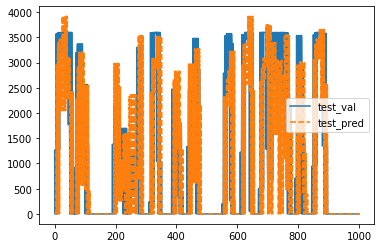

In [29]:
out_df = predict(model, X_test, y_test, time_step=5, n_features=1)

In [45]:
test_acc(out_df, at_most = 1) # accuracy if predictions are within 1 sec

RMSE = 896.6900889066011
ACC = 50.54945054945055


In [43]:
test_acc(out_df, at_most = 180) # accuracy if predictions are within 3 mins

RMSE = 896.6900889066011
ACC = 54.04595404595405


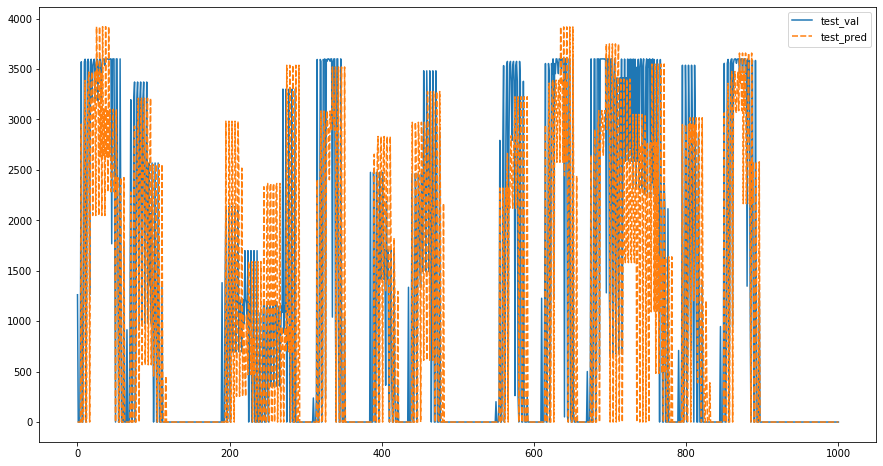

In [38]:
plt.figure(figsize=(15,8))
sns.lineplot(out_df[['test_val', 'test_pred']])

In [219]:
chrome = apps['chrome.exe']
time_step = 5
n_features = 1
X_train, X_test, y_train, y_test = feats(chrome, time_step=5, test_ratio=0.2)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu'), input_shape=(time_step, n_features)))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError(
    reduction="auto", name="mean_absolute_error"
), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=200, verbose=0)

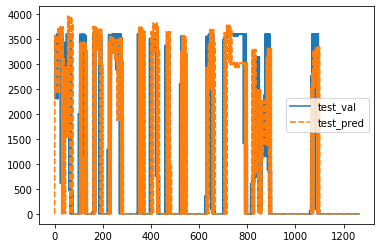

In [220]:
out_df = predict(model, X_test, y_test, time_step=5, n_features=1)

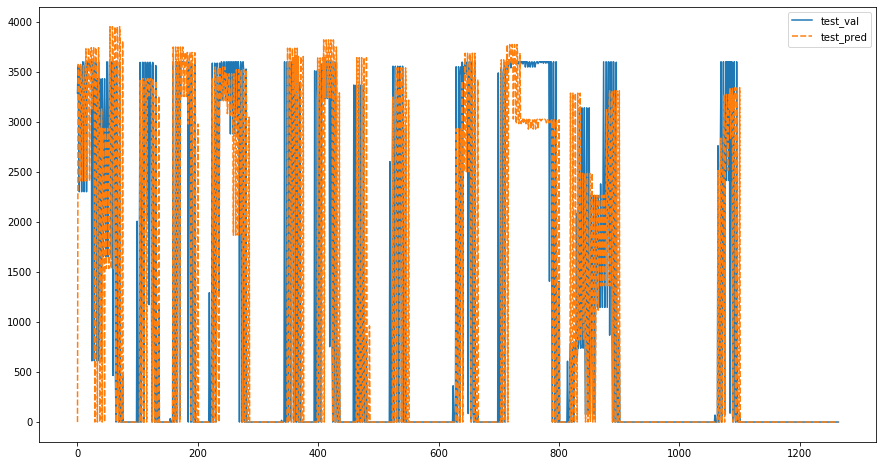

In [224]:
plt.figure(figsize=(15,8))
sns.lineplot(out_df[['test_val', 'test_pred']])

In [225]:
test_acc(out_df, at_most = 1)

RMSE = 938.3587213544401
ACC = 60.47430830039525


In [230]:
test_acc(out_df, at_most = 15)

RMSE = 938.3587213544401
ACC = 61.42292490118577


In [223]:
test_acc(out_df, at_most = 180)

RMSE = 938.3587213544401
ACC = 70.51383399209486


In [229]:
test_acc(out_df, at_most = 300)

RMSE = 938.3587213544401
ACC = 73.67588932806323
